# 0 Settings

The Car part data set is very huge, and our school's HPC cannot run the jupyter notebook for training and analysis, so here we can only use a small dataset (ca 1000 samples) to display the code can run normaly.

If you want to use the code, please check the setting parts：
- Corresponding file path
- Device settings 
- Hyperparameters

We strongly recommend that you use the school’s GPU node. By now we found a way to use the Jupyter on the temporary active node, but very unstable. see the [git:https://github.com/baixianger/02456_car_segmentation/tree/main/docs]

In [49]:
import os
import torch

## Load code from local to DTU HPC 上传代码:
#  rsync -av /Users/baixiang/car/<model file>  s213120@transfer.gbar.dtu.dk:/work3/s213120/car
## Download the output gird_img from HPC 下载雪碧图:
#  rsync -av s213120@transfer.gbar.dtu.dk:/work3/s213120/car/<model file>/save/<sub model file>/img  /Users/baixiang/Downloads
## Go to the project dir 打开工程目录
#  cd /work3/s213120/car/<model file>/

# Data setting (use a small dataset for example)
car_parts = ['background','front_door','back_door','fender','frame','bumper','hood','back_bumper','trunk']
num_classes = 9
data_path = r'./small_data'
train_size = 128
val_size = 128
test_size = 320 - 128 -128

# Model setting
back_bone = 'vgg'
model_type = 'unet'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = os.path.join('./save',model_type) # /fcn
save_freq = 1

# Hyperparameters setting
batch_size = 1 # if use A100 GPU
epochs = 1
lr = 1e-3

# Resume training
# ckpt_path is null, restart training, elif give a typical path, resume training
ckpt_path = False 
# ckpt_path = os.path.join(save_path, f'130.ckpt')

# Test setting
model_path = os.path.join(save_path,'200.ckpt')

# GPU setting
if torch.cuda.is_available():
    if torch.cuda.device_count()==2:
        os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'
    elif torch.cuda.device_count()==1:
        device_id = '0'
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Recurrent seed
recurrent_generator = torch.manual_seed(42)

#  1 DataSet

## 1.1 Data Demonstration

The first 3 elements of each npy file are the three RGB channels of the original image, the fourth element is the background mask, the 5th-12th element is the mask of the vehicle module, and the 13th element is the mixed mask of all the modules of the vehicle.

ImageNet : mean = [0.485,0.456,0.406], std = [0.229,0.224,0.225]

In [50]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset

mean = np.array([0.485,0.456,0.406])
std  = np.array([0.229,0.224,0.225])

def image_size_alignment(path,size=(256,256)):
    img = Image.open(path)
    temp = max(img.size)
    mask = Image.new('RGB', (temp,temp),(0,0,0))
    mask.paste(img,(0,0))
    mask.resize(size)
    return mask

def image_dim_expansion(tensor, num_classes=num_classes, device=device):
    images = torch.empty((num_classes,3,256,256),device=device)
    for i in range(num_classes):
        images[i] = torch.stack([tensor[i],tensor[i],tensor[i]], dim=0)
    return images

class CarDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.names = os.listdir(path)
        for i, name in enumerate(self.names):
            if os.path.splitext(name)[1] != '.npy':
                # three way to delete, pop(index), del list[index], remove(value). and clear() wipe out all
                self.names.pop(i)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        name = self.names[index]
        path = os.path.join(self.path, name)
        img = np.load(path).astype(np.double)
        car_img = img[:3] # normalized 3 channel
        mask_imgs = img[3:12]
        return torch.from_numpy(car_img).to(dtype=torch.float32), \
               torch.from_numpy(mask_imgs).to(dtype=torch.float32) # 32bit is faster than 64bit

### 1.2 Unit test

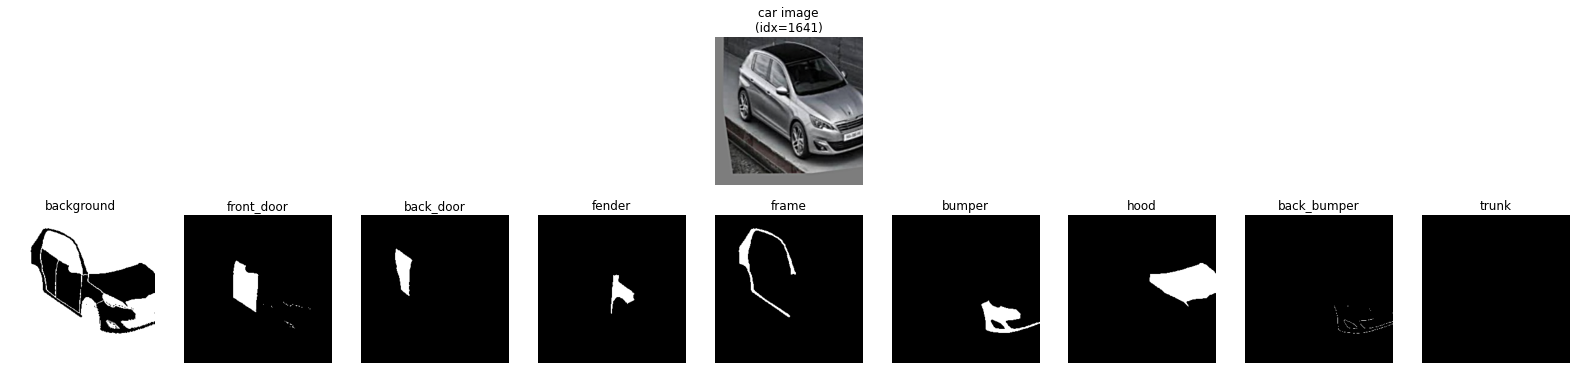

In [51]:
import random

data = CarDataset(data_path)
idx = random.randint(0,len(data))
car_img, car_masks = data[idx]

# transpose channel dim and de-nomalization
car_img = ((car_img.numpy().transpose(1,2,0) + mean / std) * 255).astype(np.int32)
car_masks = (car_masks.numpy().transpose(1,2,0) * 255).astype(np.int32)
plt.figure(figsize=(28,6))
plt.subplot(2,9,5)
plt.axis('off')
plt.imshow(car_img)
plt.title(f'car image\n(idx={idx})')
for i in range(9):
    plt.subplot(2,9,i+10)
    plt.axis('off')
    plt.imshow(car_masks[:,:,i], cmap=plt.cm.gray)
    plt.title(f'{car_parts[i]}')

torch.Size([2, 9, 256, 256]) torch.Size([2, 3, 256, 256])
torch.Size([9, 3, 256, 256]) torch.Size([9, 3, 256, 256]) torch.Size([9, 3, 256, 256])
torch.Size([27, 3, 256, 256])


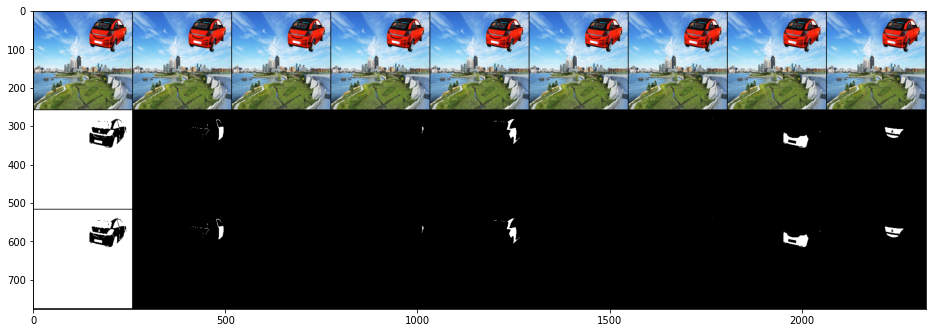

In [77]:
# test make grid
from torch.utils.data import random_split, DataLoader
from torchvision.utils import save_image

data = CarDataset(data_path)
data_loader = DataLoader(data, batch_size=2)

image, target = iter(data_loader).next()
image  = image.cpu() 
target = target.cpu()
print(target.size(), image.size())

_mask = image_dim_expansion(target[0])
_out = image_dim_expansion(target[0])
image = image[0] + (mean/std).reshape(3,1,1)
_img = torch.stack([image,image,image,image,image,image,image,image,image], dim=0)
print(_mask.size(), _out.size(), _img.size())
_concat_img = torch.cat([_img.cpu(), _mask.cpu(), _out.cpu()],dim=0)
print(_concat_img.size())

if not os.path.exists(os.path.join(save_path)):
    os.makedirs(os.path.join(save_path))
if os.path.exists(os.path.join(save_path,f'{model_type}_test_grid_images.png')):
    os.remove(os.path.join(save_path,f'{model_type}_test_grid_images.png'))
                  
save_image(_concat_img, os.path.join(save_path,f'{model_type}_test_grid_images.png'), nrow=9)

plt.figure(figsize=(16,6))
img = plt.imread(os.path.join(save_path,f'{model_type}_test_grid_images.png'))
plt.imshow(img)

torch.Size([256, 256]) torch.Size([9, 256, 256])


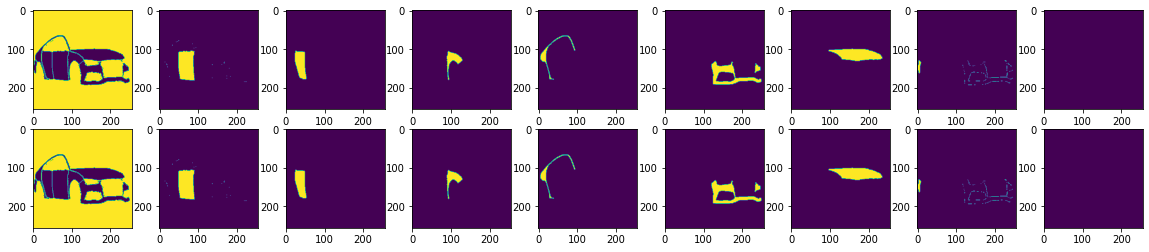

In [78]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pylab as plt

output = np.load(os.path.join(data_path,'62.npy'))[3:12]
output = torch.from_numpy(output)

output = F.softmax(output,dim=0)
_out  = F.one_hot(output.argmax(dim=0), 9).permute(2,0,1)

print(output.argmax(dim=0).size(),_out.size())

plt.figure(figsize=(20,4))
for i in range(9):
    plt.subplot(2,9,i+1)
    plt.imshow(output[i])
    plt.subplot(2,9,i+10)
    plt.imshow(_out[i])    

# 2 Network

## 2.1 FCN

In [54]:
import torch.nn as nn
from torchvision.models import vgg16

class VGG(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG, self).__init__()
        # conv1 1/2
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # conv2 1/4
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # conv3 1/8
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # conv4 1/16
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # conv5 1/32
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # load pretrained params from torchvision.models.vgg16(pretrained=True)
        # transfer-learning then fine-tune
        if pretrained:
            pretrained_model = vgg16(pretrained=pretrained)
            pretrained_params = pretrained_model.state_dict()
            keys = list(pretrained_params.keys())
            new_dict = {}
            for index, key in enumerate(self.state_dict().keys()):
                new_dict[key] = pretrained_params[keys[index]]
            self.load_state_dict(new_dict)

    def forward(self, x):
        x = self.relu1_1(self.conv1_1(x))
        x = self.relu1_2(self.conv1_2(x))
        x = self.pool1(x)
        pool1 = x

        x = self.relu2_1(self.conv2_1(x))
        x = self.relu2_2(self.conv2_2(x))
        x = self.pool2(x)
        pool2 = x

        x = self.relu3_1(self.conv3_1(x))
        x = self.relu3_2(self.conv3_2(x))
        x = self.relu3_3(self.conv3_3(x))
        x = self.pool3(x)
        pool3 = x

        x = self.relu4_1(self.conv4_1(x))
        x = self.relu4_2(self.conv4_2(x))
        x = self.relu4_3(self.conv4_3(x))
        x = self.pool4(x)
        pool4 = x

        x = self.relu5_1(self.conv5_1(x))
        x = self.relu5_2(self.conv5_2(x))
        x = self.relu5_3(self.conv5_3(x))
        x = self.pool5(x)
        pool5 = x

        return pool1, pool2, pool3, pool4, pool5

In [55]:
import torch.nn as nn
import torch

class FCN32s(nn.Module):
    def __init__(self, num_classes, backbone="vgg"):
        super(FCN32s, self).__init__()
        self.num_classes = num_classes
        if backbone == "vgg":
            self.features = VGG()

        # deconv1 1/16
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        # deconv1 1/8
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        # deconv1 1/4
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # deconv1 1/2
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # deconv1 1/1
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.features(x)

        y = self.bn1(self.relu1(self.deconv1(features[4])))

        y = self.bn2(self.relu2(self.deconv2(y)))

        y = self.bn3(self.relu3(self.deconv3(y)))

        y = self.bn4(self.relu4(self.deconv4(y)))

        y = self.bn5(self.relu5(self.deconv5(y)))

        y = self.classifier(y)

        return y


class FCN16s(nn.Module):
    def __init__(self, num_classes, backbone="vgg"):
        super(FCN16s, self).__init__()
        self.num_classes = num_classes
        if backbone == "vgg":
            self.features = VGG()

        # deconv1 1/16
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        # deconv1 1/8
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        # deconv1 1/4
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # deconv1 1/2
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # deconv1 1/1
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.features(x)

        y = self.bn1(self.relu1(self.deconv1(features[4])) + features[3])

        y = self.bn2(self.relu2(self.deconv2(y)))

        y = self.bn3(self.relu3(self.deconv3(y)))

        y = self.bn4(self.relu4(self.deconv4(y)))

        y = self.bn5(self.relu5(self.deconv5(y)))

        y = self.classifier(y)

        return y


class FCN8s(nn.Module):
    def __init__(self, num_classes, backbone="vgg"):
        super(FCN8s, self).__init__()
        self.num_classes = num_classes
        if backbone == "vgg":
            self.features = VGG()

        # deconv1 1/16
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        # deconv1 1/8
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        # deconv1 1/4
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # deconv1 1/2
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # deconv1 1/1
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.features(x)

        y = self.bn1(self.relu1(self.deconv1(features[4])) + features[3])

        y = self.bn2(self.relu2(self.deconv2(y)) + features[2])

        y = self.bn3(self.relu3(self.deconv3(y)))

        y = self.bn4(self.relu4(self.deconv4(y)))

        y = self.bn5(self.relu5(self.deconv5(y)))

        y = self.classifier(y)

        return y


class FCNs(nn.Module):
    def __init__(self, num_classes, backbone="vgg"):
        super(FCNs, self).__init__()
        self.num_classes = num_classes
        if backbone == "vgg":
            self.features = VGG()

        # deconv1 1/16
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        # deconv1 1/8
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU()

        # deconv1 1/4
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        # deconv1 1/2
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # deconv1 1/1
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.features(x)

        y = self.bn1(self.relu1(self.deconv1(features[4])) + features[3])

        y = self.bn2(self.relu2(self.deconv2(y)) + features[2])

        y = self.bn3(self.relu3(self.deconv3(y)) + features[1])

        y = self.bn4(self.relu4(self.deconv4(y)) + features[0])

        y = self.bn5(self.relu5(self.deconv5(y)))

        y = self.classifier(y)

        return y

### 2.2.1 Unit test 单元测试

In [56]:
## assume we have 9 classes, and input is a 3-channel image.
## if __name__ == '__main__':
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(8, 3, 256, 256).to(device)

model = FCN32s(9).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

model = FCN16s(9).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

model = FCN8s(9).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

model = FCNs(9).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

### 2.2.2 Network Summary

In [57]:
from torchsummary import summary
model = FCN8s(9).to(device)
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

## 2.2 UNet

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, skip=2):
        # For UNet   skip = 2, 
        # For UNet++ skip = 2 in UNet(L1), 3 in UNet(L2), 4 in UNet(l3),...
        super().__init__()
        self.skip = skip
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels * skip, out_channels)

    def forward(self, x1, *args):
        assert self.skip == len(args) + 1
        x1 = self.up(x1)
        x = torch.cat([*args, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=num_classes):
        super(UNet, self).__init__()
        self.n_classes = n_classes

        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        y = self.outc(x)
        return y

class UNet_pp(nn.Module):
    def __init__(self, n_classes=num_classes, deep_supervision=False):
        super(UNet_pp, self).__init__()
        self.n_classes = n_classes
        self.deep_supervision = deep_supervision
        nb_filter = [32, 64, 128, 256, 512]

        self.conv0_0 = DoubleConv(3, 64)
        self.conv1_0 = Down( 64, 128)
        self.conv2_0 = Down(128, 256)
        self.conv3_0 = Down(256, 512)
        self.conv4_0 = Down(512, 1024)

        self.conv0_1 = Up( 128,  64, 2)
        self.conv1_1 = Up( 256, 128, 2)
        self.conv2_1 = Up( 512, 256, 2)
        self.conv3_1 = Up(1024, 512, 2)

        self.conv0_2 = Up( 128,  64, 3)
        self.conv1_2 = Up( 256, 128, 3)
        self.conv2_2 = Up( 512, 256, 3)

        self.conv0_3 = Up( 128,  64, 4)
        self.conv1_3 = Up( 256, 128, 4)

        self.conv0_4 = Up( 128,  64, 5)

        if self.deep_supervision:
            self.outc1 = OutConv(64, n_classes)
            self.outc2 = OutConv(64, n_classes)
            self.outc3 = OutConv(64, n_classes)
            self.outc4 = OutConv(64, n_classes)
        else:
            self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x0_0 = self.conv0_0(x)

        x1_0 = self.conv1_0(x0_0)
        x0_1 = self.conv0_1(x1_0, x0_0)

        x2_0 = self.conv2_0(x1_0)
        x1_1 = self.conv1_1(x2_0, x1_0)
        x0_2 = self.conv0_2(x1_1, x0_0, x0_1)

        x3_0 = self.conv3_0(x2_0)
        x2_1 = self.conv2_1(x3_0, x2_0)
        x1_2 = self.conv1_2(x2_1, x1_0, x1_1)
        x0_3 = self.conv0_3(x1_2, x0_0, x0_1, x0_2)

        x4_0 = self.conv4_0(x3_0)
        x3_1 = self.conv3_1(x4_0, x3_0)
        x2_2 = self.conv2_2(x3_1, x2_0, x2_1)
        x1_3 = self.conv1_3(x2_2, x1_0, x1_1, x1_2)
        x0_4 = self.conv0_4(x1_3, x0_0, x0_1, x0_2, x0_3)

        if self.deep_supervision:
            y1 = self.outc1(x0_1)
            y2 = self.outc2(x0_2)
            y3 = self.outc3(x0_3)
            y4 = self.outc4(x0_4)
            return y1, y2, y3, y4

        else:
            y = self.outc(x0_4)
            return y

In [59]:
## assume we have 9 classes, and input is a 3-channel image.
    
x = torch.randn(8, 3, 256, 256).to(device)

# UNet
model = UNet(num_classes).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

# Unet++ 
model = UNet_pp(num_classes).to(device)
y = model(x).cpu()
assert y.size() == (8,9,256,256)

# Unet++ with Deep Supervision
model = UNet_pp(num_classes,True).to(device)
y, _, _, _ = model(x)
y = y.cpu()
assert y.size() == (8,9,256,256)

In [60]:
from torchsummary import summary
model = UNet_pp(9).to(device)
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

# 3 Plot

## 3.1 Plot Train and Val Loss

In [61]:
import os
import matplotlib.pyplot as plt
import numpy as np
def plot_loss(model_name, epochs, lr, batch_size, img_name,*args):
    assert len(args) == 3
    plt.figure(figsize=(5,5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,1)
    plt.title(f'Train and Validation Loss of Model ({model_name})\n(lr:{lr} epochs:{epochs} batch_size:{batch_size})')
    plt.plot(range(1,epochs+1), np.load(args[0]), '--b', label=f'Train Loss')
    plt.plot(range(1,epochs+1), np.load(args[1]), '--r', label=f'Val Loss')
    plt.plot(range(1,epochs+1), np.load(args[2]), '-g', label=f'Val Dice Score')
    plt.legend()
    plt.grid()
    save_path = os.path.dirname(args[0])
    plt.savefig(os.path.join(save_path, img_name))
    print(f'Loss Plot save to {save_path}')

## 3.2 Plot Confusion Matrix 

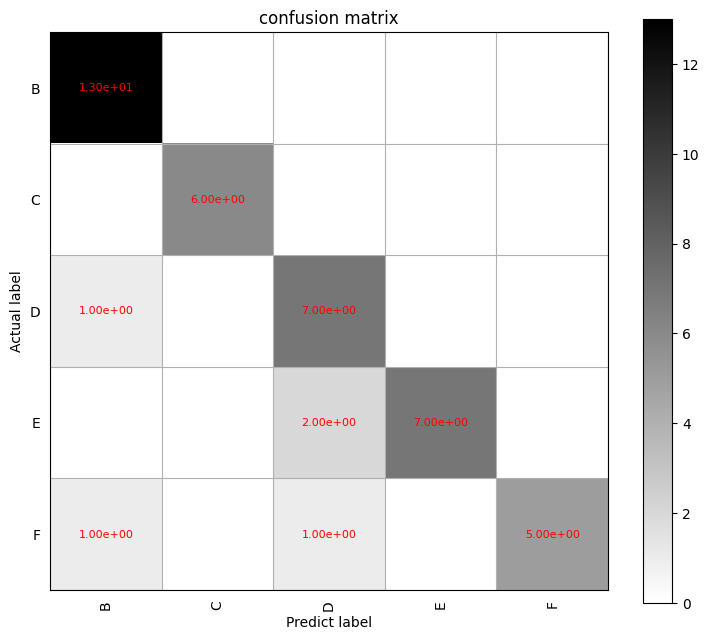

In [62]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
def plot_confusion_matrix(cm, savename, classes, title='Confusion Matrix'):

    # tackle label imbalance
    cm  = cm[1:,1:]
    classes = classes[1:]
    plt.figure(figsize=(9, 8), dpi=100)
    np.set_printoptions(precision=2)

    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2e" % (c,), color='red', fontsize=8, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()

# Test with 6 classes
classes = ['A', 'B', 'C', 'D', 'E', 'F']
random_numbers = np.random.randint(6, size=50) 
y_true = random_numbers.copy()  # 样本实际标签
random_numbers[:10] = np.random.randint(6, size=10)  
y_pred = random_numbers 
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, 'confusion_matrix.png', classes, title='confusion matrix')

# 4 Evaluate tools

In [66]:
import numpy as np
import torch
from torch import Tensor

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


def pixelAccuracy(confusionMatrix):
    # return all class overall pixel accuracy
    #  PA = acc = (TP + TN) / (TP + TN + FP + TN)
    acc = np.diag(confusionMatrix).sum() /  confusionMatrix.sum()
    return acc
 
def classPixelAccuracy(confusionMatrix):
    # return each category pixel accuracy(A more accurate way to call it precision)
    # acc = (TP) / TP + FP
    classAcc = np.diag(confusionMatrix) / confusionMatrix.sum(axis=1)
    return classAcc # 返回的是一个列表值，如：[0.90, 0.80, 0.96]，表示类别1 2 3各类别的预测准确率

def meanPixelAccuracy(confusionMatrix):
    classAcc = classPixelAccuracy(confusionMatrix)
    meanAcc = np.nanmean(classAcc) # np.nanmean 求平均值，nan表示遇到Nan类型，其值取为0
    return meanAcc # 返回单个值，如：np.nanmean([0.90, 0.80, 0.96, nan, nan]) = (0.90 + 0.80 + 0.96） / 3 =  0.89

def meanIntersectionOverUnion(confusionMatrix):
    # Intersection = TP Union = TP + FP + FN
    # IoU = TP / (TP + FP + FN)
    intersection = np.diag(confusionMatrix) # 取对角元素的值，返回列表
    union = np.sum(confusionMatrix, axis=1) + np.sum(confusionMatrix, axis=0) - np.diag(confusionMatrix) # axis = 1表示混淆矩阵行的值，返回列表； axis = 0表示取混淆矩阵列的值，返回列表 
    IoU = intersection / union  # 返回列表，其值为各个类别的IoU
    mIoU = np.nanmean(IoU) # 求各类别IoU的平均
    return mIoU

def frequency_Weighted_Intersection_over_Union(confusionMatrix):
    # FWIOU =     [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)]
    freq = np.sum(confusionMatrix, axis=1) / np.sum(confusionMatrix)
    iu = np.diag(confusionMatrix) / (
            np.sum(confusionMatrix, axis=1) + np.sum(confusionMatrix, axis=0) -
            np.diag(confusionMatrix))
    FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
    return FWIoU

# 5 Training

## 5.1 Split Dataset

In [63]:
import os
from tqdm import tqdm
import torch
import numpy as np
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
# dataset
car_dataset = CarDataset(data_path)

# Here we use a small data, change split size go to the setting part.
# train_size = 128 val_size = 128
test_size = len(car_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(car_dataset, [train_size, val_size, test_size],
                                            generator=recurrent_generator)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## 5.2 Initialization

In [64]:
 # select model type
if model_type == 'fcn32s': model = FCN32s(num_classes, back_bone)
elif model_type == 'fcn16s': model = FCN16s(num_classes, back_bone)
elif model_type == 'fcn8s': model = FCN8s(num_classes, back_bone)
elif model_type == 'fcns': model = FCNs(num_classes, back_bone)
elif model_type == 'unet': model = UNet(num_classes)
elif model_type == 'unet_pp': model = UNet_pp(num_classes)
else: print('wrong type of model')

start_epoch = 1
data_loader = DataLoader(CarDataset(data_path), batch_size,shuffle=True)

# initialize model-saving directory
if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(os.path.join(save_path,'img')):
    os.makedirs(os.path.join(save_path,'img'))
    
# resume training
if ckpt_path:
    epoch_name = (ckpt_path.split('/')[-1]).split('.')[0]
    start_epoch = int(epoch_name) + 1
    checkpoint = torch.load(ckpt_path)
    state_dict = checkpoint["state_dict"]

    model.load_state_dict(state_dict)
    print(f"Model loaded from {ckpt_path}")

# CUDA or CPU
if torch.cuda.is_available():
    model.to(device)
    model = nn.DataParallel(model) # multi-GPU

# optimizer = torch.optim.SGD(mymodel.parameters(), lr, momentum=0.9, weight_decay=0.00001)
optimizer = torch.optim.Adam(model.parameters(), lr)
# criterion = nn.BCEWithLogitsLoss() # which can be used for both binary and multi classification
criterion = nn.CrossEntropyLoss()
# scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

print('\033[31mStart training: Total epochs: {}, Batch size: {}, Training size: {}, Validation size: {}, Test size: {}\033[0m'.
                format(epochs, batch_size, len(train_set), len(val_set), len(test_set)))
print(f'NETWORK :{model_type}')

Start training: Total epochs: 1, Batch size: 1, Training size: 128, Validation size: 128, Test size: 1463
NETWORK :unet


## 5.3 Training and Validation

In [65]:
train_epoch_losses = []
val_epoch_losses = []
val_epoch_dice_scores = []  
for epoch in range(start_epoch, epochs+1):
    
    print(f'\033[31mEpoch {epoch:02d}/{epochs}\033[0m, Learning Rate {optimizer.param_groups[0]["lr"]:g}')

    # train
    model.train()
    epoch_loss = 0.0
    for i, sample in tqdm(enumerate(train_loader),desc=f'\tTrain Batches       '):
        images, targets = sample
        images  = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets) # default is mean loss
        # outputs  = F.softmax(outputs, dim=1)
        # outputs  = F.one_hot(outputs.argmax(dim=1), num_classes).permute(0, 3, 1, 2).float()
        # loss = loss + dice_loss(outputs,targets,multiclass=True)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() # save loss of every batch in each epoch

    train_epoch_losses.append(epoch_loss / train_size * batch_size)
    print(f'\tTrain Epoch Avg_Loss: {train_epoch_losses[-1]:.6f}')

    # save checkpoint model
    if epoch % save_freq == 0:
        state_dict = model.module.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].cpu()

        torch.save({
            'epoch': epoch,
            'save_dir': save_path,
            'state_dict': state_dict,},
            os.path.join(save_path, f'{epoch:03d}.ckpt'))
        print(f'\t\033[33mSave checkpoint\033[0m successfully to {save_path}: {epoch:03d}.ckpt')

    # validation
    model.eval()
    epoch_loss = 0.0
    for i, sample in tqdm(enumerate(val_loader),desc=f'\tVal   Batches       '):
        images, targets = sample
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, targets)
            outputs  = F.softmax(outputs, dim=1)
            outputs  = F.one_hot(outputs.argmax(dim=1), num_classes).permute(0, 3, 1, 2).float()
            dice_score = multiclass_dice_coeff(outputs[:, 1:, ...], targets[:, 1:, ...], reduce_batch_first=False)

            _img  = torch.stack([images[0],images[0],images[0],images[0],images[0],images[0],images[0],images[0],images[0]], dim=0)
            _mask = image_dim_expansion(targets[0])
            _out  = image_dim_expansion(outputs[0])
            _concat_img = torch.cat([_img + 2, _mask, _out],dim=0)

            save_image(_concat_img, os.path.join(save_path,'img',f'val_{i}_{epoch}.png'), nrow=9)

        epoch_loss += loss.item() # save loss of every batch in each epoch


    val_epoch_losses.append(epoch_loss / val_size * batch_size)
    val_epoch_dice_scores.append(dice_score.item())
    print(f'\tVal   Epoch Avg_Loss: {val_epoch_losses[-1]:.6f}')
    print(f'\tVal Epoch Dice score: {val_epoch_dice_scores[-1]:.6f}')
    # update learning rate
    # scheduler.step()

Epoch 01/1, Learning Rate 0.001


	Train Batches       : 128it [00:25,  5.12it/s]


	Train Epoch Avg_Loss: 0.885558
	Save checkpoint successfully to ./save/unet: 001.ckpt


	Val   Batches       : 128it [00:48,  2.61it/s]

	Val   Epoch Avg_Loss: 0.644027
	Val Epoch Dice score: 0.125000


## 5.4 Plot Training and Validation Lossand Output videos from every epochs

Save loss history to:
	./save/unet/unet_1_1_train.npy
	./save/unet/unet_1_1_val.npy
Loss Plot save to ./save/unet
130 <class 'str'> unet_test_grid_images.png
<class 'numpy.ndarray'>
Validation output has been written to ./save/unet/unet.avi!


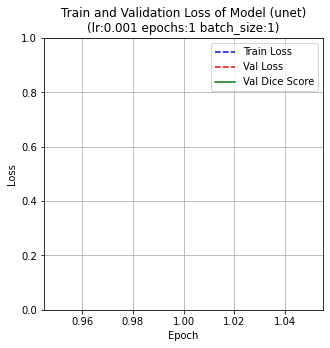

In [81]:
train_log = np.array(train_epoch_losses)
val_log   = np.array(val_epoch_losses)
val_dice   = np.array(val_epoch_dice_scores)
train_log_path  = os.path.join(save_path, f'{model_type}_{start_epoch:d}_{start_epoch-1+epochs:d}_train.npy')
val_log_path    = os.path.join(save_path, f'{model_type}_{start_epoch:d}_{start_epoch-1+epochs:d}_val.npy')
val_log_dice_path    = os.path.join(save_path, f'{model_type}_{start_epoch:d}_{start_epoch-1+epochs:d}_val_dice.npy')
np.save(train_log_path, train_log)
np.save(val_log_path, val_log)
np.save(val_log_dice_path, val_dice)
print(f'Save loss history to:\n\t{train_log_path}\n\t{val_log_path}')

plot_loss(model_type, epochs, lr, batch_size, 'loss.jpg', train_log_path, val_log_path, val_log_dice_path)

import cv2
# image path
img_path = os.path.join(save_path,'img')
# output video path
video_path = os.path.join(save_path)
if not os.path.exists(video_path):
    os.makedirs(video_path)
# set saved fps
fps = 5
# get frames list
frames = sorted(os.listdir(img_path))
print(len(frames), type(frames[1]), frames[1])
# w,h of image
img = cv2.imread(os.path.join(img_path, frames[1]))
print(type(img))
img_size = (img.shape[1], img.shape[0])
# get seq name
seq_name = os.path.dirname(img_path).split('/')[-1]
# splice video_path
video_path = os.path.join(video_path, seq_name + '.avi')
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
# also can write like:fourcc = cv2.VideoWriter_fourcc(*'MJPG')
# if want to write .mp4 file, use 'MP4V'
videowriter = cv2.VideoWriter(video_path, fourcc, fps, img_size)

for frame in frames:
    f_path = os.path.join(img_path, frame)
    image = cv2.imread(f_path)
    videowriter.write(image)
print(f'Validation output has been written to {video_path}!')

videowriter.release()


# 6 Model Evaluation and Testing

Model loaded from ./save/unet/001.ckpt
NETWORK :unet


Test Batches: 1463it [09:11,  2.65it/s]


	Test Dice score: 0.213560
Pixel Accuracy: 0.8592407685473449
Class Pixel Accuracy: [1.   0.   0.   0.   0.09 0.   0.   0.   0.  ]
Mean Pixel Accuracy: 0.12056123072784065
Mean Intersection over Union: 0.10426761172059361
Frequency Weighted Intersection over Union: 0.7398055839142004


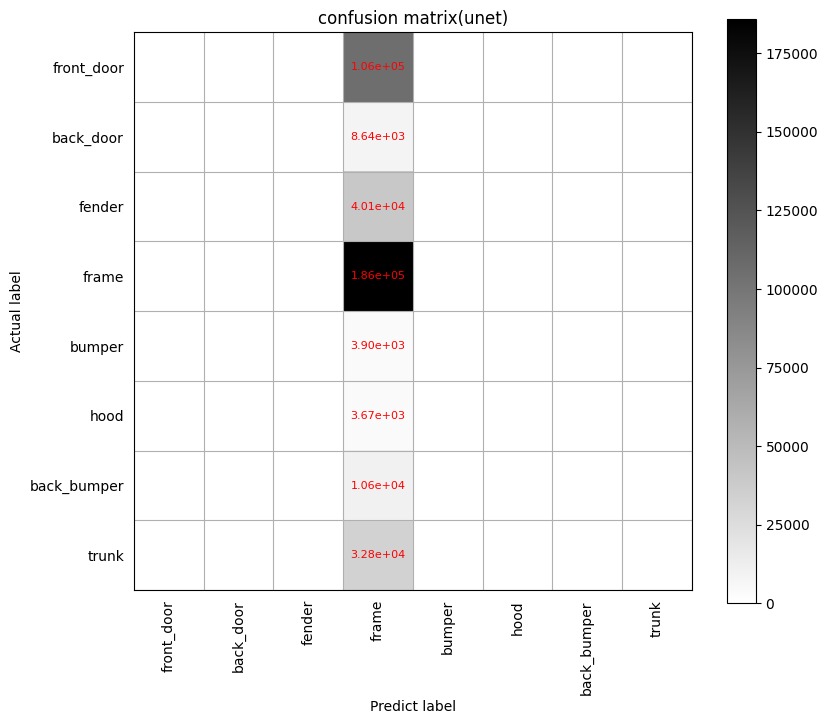

In [85]:
test_batch_size = 1

 # select model type
if model_type == 'fcn32s': model = FCN32s(num_classes, back_bone)
elif model_type == 'fcn16s': model = FCN16s(num_classes, back_bone)
elif model_type == 'fcn8s': model = FCN8s(num_classes, back_bone)
elif model_type == 'fcns': model = FCNs(num_classes, back_bone)
elif model_type == 'unet': model = UNet(num_classes)
elif model_type == 'unet_pp': model = UNet_pp(num_classes)
else: print('wrong type of model')

start_epoch = 1
data_loader = DataLoader(CarDataset(data_path), batch_size,shuffle=True)

model_path = os.path.join(save_path,'001.ckpt')
checkpoint = torch.load(model_path)
state_dict = checkpoint["state_dict"]

model.load_state_dict(state_dict)
print(f"Model loaded from {model_path}")

# CUDA or CPU
if torch.cuda.is_available():
    model.to(device)
    model = nn.DataParallel(model) # multi-GPU

# dataset
car_dataset = CarDataset(data_path)

# split data [0.7, 0.15, 0.15]
# train_size see from setting part
# val_size see from setting part
test_size = len(car_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(car_dataset, [train_size, val_size, test_size],
                                            generator=recurrent_generator)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f'NETWORK :{model_type}')

# test
model.eval()
test_loss  = 0
dice_score = 0
out_cpu = torch.empty([test_size,256,256])
tar_cpu = torch.empty([test_size,256,256])
for i, sample in tqdm(enumerate(test_loader),desc=f'Test Batches'):
    images, targets = sample
    images = images.to(device)
    targets = targets.to(device)
    with torch.no_grad():
        outputs = model(images)
        outputs  = F.softmax(outputs, dim=1)
        outputs  = outputs.argmax(dim=1)
        # move prediction to cpu
        out_cpu[i*batch_size : (i+1)*batch_size] = outputs.cpu()
        tar_cpu[i*batch_size : (i+1)*batch_size] = targets.argmax(dim=1).cpu()
        outputs  = F.one_hot(outputs, num_classes).permute(0, 3, 1, 2).float()
        dice_score += multiclass_dice_coeff(outputs[:, 1:, ...], targets[:, 1:, ...], reduce_batch_first=False)

        _img  = torch.stack([images[0],images[0],images[0],images[0],images[0],images[0],images[0],images[0],images[0]], dim=0)
        _mask = image_dim_expansion(targets[0])
        _out  = image_dim_expansion(outputs[0])
        _concat_img = torch.cat([_img + 2, _mask, _out],dim=0)

        save_image(_concat_img, os.path.join(save_path,'img',f'test_{i}.png'), nrow=9)

dice_score = dice_score / (i+1)
print(f'\tTest Dice score: {dice_score:.6f}')

out_cpu = out_cpu.ravel().numpy()
tar_cpu = tar_cpu.ravel().numpy()


classes = ['background','front_door','back_door','fender','frame','bumper','hood','back_bumper','trunk']
cm = confusion_matrix(tar_cpu, out_cpu)
print('Pixel Accuracy:',pixelAccuracy(cm))
print('Class Pixel Accuracy:',classPixelAccuracy(cm))
print('Mean Pixel Accuracy:',meanPixelAccuracy(cm))
print('Mean Intersection over Union:',meanIntersectionOverUnion(cm))
print('Frequency Weighted Intersection over Union:',frequency_Weighted_Intersection_over_Union(cm))
plot_confusion_matrix(cm, f'confusion_matrix_{model_type}.png', classes, title=f'confusion matrix({model_type})')
